In [1]:
import time
import re
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait # available since 2.4.0
from selenium.webdriver.support import expected_conditions as EC # available since 2.26.0
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from sklearn.preprocessing import StandardScaler

from secrets import *

In [2]:
email = AUTH["email"]
password = AUTH["password"]

## LOGIN

In [3]:
# https://stackoverflow.com/questions/33326459/logging-into-espn-using-selenium

In [83]:
driver = webdriver.Chrome()

In [84]:
driver.get("http://games.espn.go.com/ffl/signin")

In [85]:
w = WebDriverWait(driver,1000).until(EC.presence_of_all_elements_located((By.XPATH,"(//iframe)")))

In [86]:
driver.switch_to_frame("disneyid-iframe")
time.sleep(2)

/Users/codyschank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: use driver.switch_to.frame instead
  """Entry point for launching an IPython kernel.


In [87]:
driver.find_element_by_css_selector('input[type=email]').send_keys(email)

In [88]:
driver.find_element_by_css_selector('input[type=password]').send_keys(password)

In [89]:
driver.find_element_by_xpath("//button").click()

## STATS

In [90]:
leagueID = "84057"
url = "http://fantasy.espn.com/basketball/players/add?leagueId="+leagueID+"&view=stats"
url

'http://fantasy.espn.com/basketball/players/add?leagueId=84057&view=stats'

In [91]:
driver.get(url)

In [92]:
# show all players
driver.find_element_by_xpath("//*[@id='filterStatus']/option[1]").click()

In [93]:
# show totals
driver.find_element_by_xpath("//*[@id='espn-analytics']/div/div[5]/div[2]/div[2]/div/div/div[1]/div/div[3]/label[1]/div").click()

In [94]:
xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody'
table = driver.find_element_by_xpath(xpath)

In [105]:
cells = table.text.split('\n')

In [96]:
nba_teams = ['Hou','Mil','No','GS','LAL','OKC','Phi','Min','Por','Ind','Tor','Den','Bos','SA','Wsh','Utah','Cle','Det',
            'Cha','Phx','Dal','Mem','LAC','Mia','Atl','NY','Orl','Chi','Sac','Bkn']

In [114]:
# clean out unnecessary/ complicating data
cells = [i for i in cells if i not in ['O','DTD']]
cells = [i for i in cells if i not in nba_teams]
cells = [i for i in cells if '@' not in i]
cells = [i for i in cells if ':' not in i]
players = cells[6:cells.index('STATS RESEARCH')]
stats = cells[(cells.index('+/-')+1):] # find '+/-', and start from the cell after that?

In [115]:
players = [i for i in players if '--' not in i]

In [116]:
columns = ['player','position','fantasy_team','minutes','fgm/fga','fg%','ftm/fta','ft%','3pm','reb','ast','stl','blk','pts','pr5','own','change']
statsTable = pd.DataFrame()

In [117]:
j = 0
k = 0
for i in range(50):
    player = players[j:j+3]
    j = j+3
    player_stats = stats[k:k+14]
    k = k+14
    values = player+player_stats
    row = dict(zip(columns, values))
    statsTable = statsTable.append(row, ignore_index=True)

In [119]:
#statsTable.head(50)

In [82]:
# this is another way to do it, with less cleanging post scraprin, but hits that page many more times, and thus flags the account
'''for i in range(1,51):
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody/tr/td[1]/table/tbody/tr[' + str(i) + ']/td[1]'
    playername = driver.find_element_by_xpath(xpath)
    playername = playername.text.split('\n')
    playername = [j for j in playername if j not in ['O','DTD']]
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody/tr/td[1]/table/tbody/tr[' + str(i) + ']/td[2]'
    fantasyteam = driver.find_element_by_xpath(xpath)
    fantasyteam = fantasyteam.text.split('\n')
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody/tr/td[2]/div/div/div[2]/table/tbody/tr/td/table/tbody/tr[' + str(i) + ']'
    stats = driver.find_element_by_xpath(xpath)
    stats = stats.text.split('\n')
    values = playername+fantasyteam+stats
    row = dict(zip(columns, values))
    statsTable = statsTable.append(row, ignore_index=True)
''' and None

In [120]:
for i in range(2,6):
    next_page = "//*[@id='espn-analytics']/div/div[5]/div[2]/div[2]/div/div/div[2]/div/div/ul/li["+str(i)+"]"
    driver.find_element_by_xpath(next_page).click()
    time.sleep(4)
    xpath = '//*[@id="espn-analytics"]/div/div[5]/div[2]/div[2]/div/div/div[2]/section/table/tbody'
    table = driver.find_element_by_xpath(xpath)
    cells = table.text.split('\n')
    cells = [i for i in cells if i not in ['O','DTD']]
    cells = [i for i in cells if i not in nba_teams]
    cells = [i for i in cells if '@' not in i]
    cells = [i for i in cells if ':' not in i]
    players = cells[6:cells.index('STATS RESEARCH')]
    players = [i for i in players if '--' not in i]
    stats = cells[(cells.index('+/-')+1):] 
    j = 0
    k = 0
    for i in range(50):
        player = players[j:j+3]
        j = j+3
        player_stats = stats[k:k+14]
        k = k+14
        values = player+player_stats
        row = dict(zip(columns, values))
        statsTable = statsTable.append(row, ignore_index=True)

In [121]:
statsTable.shape

(250, 17)

In [123]:
#statsTable.tail(50)

## ANALYZE

In [124]:
statsTable['fta'] = statsTable['ftm/fta'].str.split('/',expand=True)[1]
statsTable['fga'] = statsTable['fgm/fga'].str.split('/',expand=True)[1]
statsTable = statsTable.drop(columns = ['pr5','own','change','ftm/fta','fgm/fga'])

In [125]:
statsTable = statsTable.replace("--","0")

In [126]:
statsTable['ast'] = pd.to_numeric(statsTable['ast']) 
statsTable['blk'] = pd.to_numeric(statsTable['blk']) 
statsTable['reb'] = pd.to_numeric(statsTable['reb']) 
statsTable['pts'] = pd.to_numeric(statsTable['pts']) 
statsTable['stl'] = pd.to_numeric(statsTable['stl'])
statsTable['3pm'] = pd.to_numeric(statsTable['3pm'])
statsTable['ft%'] = pd.to_numeric(statsTable['ft%'])
statsTable['fg%'] = pd.to_numeric(statsTable['fg%'])
statsTable['fta'] = pd.to_numeric(statsTable['fta'])
statsTable['fga'] = pd.to_numeric(statsTable['fga'])
statsTable['minutes'] = pd.to_numeric(statsTable['minutes'])

In [127]:
scaler = StandardScaler()

In [128]:
statsTable[['ast', 'blk','reb','pts','stl','3pm','ft%','fg%','fta','fga']] = scaler.fit_transform(statsTable[['ast', 'blk','reb','pts','stl','3pm','ft%','fg%','fta','fga']])

In [129]:
statsTable.head()

,3pm,ast,blk,fantasy_team,fg%,ft%,min,player,position,pts,reb,stl,fta,fga
0,-0.906412,1.111689,0.303062,DEKK,0.284258,-0.016626,67,Giannis Antetokounmpo,"PF, SF",1.002495,2.335029,0.112311,1.266961,1.294792
1,-0.590809,1.277020,1.926606,DOIS,1.115758,0.371797,66,Anthony Davis,"PF, C",1.293806,1.560815,1.831351,1.897289,0.589568
2,-0.590809,0.781026,-0.238120,BEB,0.268569,0.587272,76,LeBron James,"SF, PF",0.953944,0.565397,0.685324,1.424543,0.910124
3,2.880826,3.756992,0.303062,Wood,0.143060,0.437007,113,James Harden,"SG, PG",2.653253,0.897203,2.977377,2.842782,2.320573
4,-0.590809,2.269009,0.844243,Cod,0.205815,0.899144,117,Kevin Durant,"SF, PF",2.653253,1.782019,0.685324,3.000364,2.641130


In [130]:
statsTable['fga_adj'] = statsTable['fga'] + abs(statsTable['fga'].min())
statsTable['fta_adj'] = statsTable['fta'] + abs(statsTable['fta'].min())

In [131]:
statsTable['fg%_adj'] = statsTable['fg%'] * statsTable['fga_adj']
statsTable['ft%_adj'] = statsTable['ft%'] * statsTable['fta_adj']

In [132]:
statsTable[['fg%_adj','ft%_adj']] = scaler.fit_transform(statsTable[['fg%_adj','ft%_adj']])

In [133]:
statsTable = statsTable.drop(columns = ['fga_adj','fta_adj','fg%','ft%','fta','fga'])

In [134]:
statsTable['cumulative'] = statsTable['ft%_adj'] + statsTable['fg%_adj'] + statsTable['ast'] + statsTable['blk'] + statsTable['pts'] + statsTable['reb'] + statsTable['stl'] + statsTable['3pm']  

In [135]:
statsTable = statsTable.sort_values('cumulative',ascending=False)

In [136]:
statsTable.head()

,3pm,ast,blk,fantasy_team,min,player,position,pts,reb,stl,fg%_adj,ft%_adj,cumulative
10,0.356000,2.599672,0.844243,DEKK,97,Nikola Jokic,C,2.361943,2.113825,1.831351,2.638209,3.290350,16.035592
3,2.880826,3.756992,0.303062,Wood,113,James Harden,"SG, PG",2.653253,0.897203,2.977377,0.236406,1.534454,15.239572
6,4.143239,2.765003,-0.779301,gov,113,Stephen Curry,PG,3.041666,0.454795,0.685324,1.761929,1.025587,13.098244
20,5.090049,1.607683,-0.779301,WILL,106,Kemba Walker,PG,3.672838,-0.319418,0.685324,1.472535,0.893886,12.323596
4,-0.590809,2.269009,0.844243,Cod,117,Kevin Durant,"SF, PF",2.653253,1.782019,0.685324,0.585133,3.985016,12.213187


## My team

In [150]:
my_team = statsTable.loc[statsTable.fantasy_team == 'Cod']
my_team = my_team.loc[my_team['minutes'] > 0]

In [151]:
my_team.shape

(13, 13)

In [152]:
my_team

,3pm,ast,blk,fantasy_team,min,player,position,pts,reb,stl,fg%_adj,ft%_adj,cumulative
4,-0.590809,2.269009,0.844243,Cod,117,Kevin Durant,"SF, PF",2.653253,1.782019,0.685324,0.585133,3.985016,12.213187
8,0.671604,1.111689,-0.238120,Cod,65,Damian Lillard,PG,1.293806,-0.430020,-0.460703,0.671357,2.902963,5.522575
116,0.987207,-0.045631,0.303062,Cod,82,Buddy Hield,SG,1.099599,0.122989,-0.460703,1.549823,-0.293846,3.262500
88,0.356000,2.599672,-0.238120,Cod,96,Dennis Schroder,PG,0.614082,0.233591,1.258337,-3.100909,1.467630,3.190284
125,0.356000,-0.045631,0.844243,Cod,74,Jeremy Lamb,"SG, SF",-0.017090,0.233591,1.831351,-1.410912,0.703909,2.495460
157,1.934017,-0.210963,0.303062,Cod,83,Malik Monk,SG,0.662634,-0.651224,0.112311,-0.575513,0.044192,1.618514
23,-0.906412,0.119700,1.385424,Cod,79,LaMarcus Aldridge,"PF, C",0.128565,1.671417,0.112311,-1.232080,-0.430568,0.848356
136,0.987207,0.285031,-0.238120,Cod,66,Trevor Ariza,SF,-0.211297,-0.098215,-0.460703,-0.016776,-0.175713,0.071415
22,-0.590809,-0.706957,0.303062,Cod,56,Andre Drummond,C,0.177117,2.335029,-1.033716,-0.150541,-0.293846,0.039338
83,0.671604,-0.706957,-0.238120,Cod,46,TJ Warren,SF,0.128565,-0.872428,0.112311,0.318258,0.264098,-0.322670


In [153]:
my_team[['ast','blk','pts','reb','stl','3pm','ft%_adj','fg%_adj']].sum(axis=0)

ast        5.524054
blk        1.775075
pts        5.458376
reb        6.022941
stl        2.606065
3pm        3.681196
ft%_adj    7.156133
fg%_adj   -7.616571
dtype: float64

In [164]:
opp_team =  statsTable.loc[statsTable.fantasy_team == 'BEB']

In [166]:
opp_team = opp_team.loc[opp_team['minutes'] > 0]

In [168]:
# diff
my_team[['ast','blk','pts','reb','stl','3pm','ft%_adj','fg%_adj']].sum(axis=0) - opp_team[['ast','blk','pts','reb','stl','3pm','ft%_adj','fg%_adj']].sum(axis=0)

ast       -1.368283
blk       -1.320482
pts        2.410494
reb        0.675999
stl        0.112311
3pm        1.934017
ft%_adj    8.215823
fg%_adj   -8.228711
dtype: float64

In [ ]:
# rather than use PR, use stat averages, and num games played during the matchup.

## Some plots

In [ ]:
# 14 players on roster including IR, so let's focus on 12*14 = 168 players
# but there is a pool of free agents that people would consider adding. I think 250 could be a good number.

In [112]:
statsTable.iloc[168]

3pm                 -1.01073
ast                -0.820302
blk                  0.32161
fantasy_team              FA
player          Gorgui Dieng
position               C, PF
pts                -0.959479
reb                 0.191803
stl                 -0.15438
fg%_adj             0.285291
ft%_adj           -0.0243125
cumulative           -2.1705
Name: 230, dtype: object

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


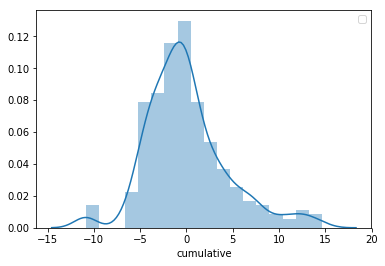

In [111]:
sns.distplot(statsTable.cumulative)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


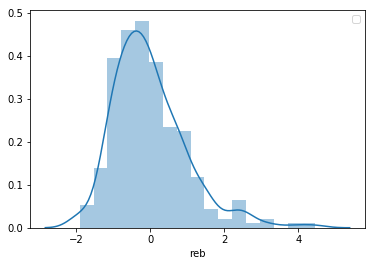

In [113]:
sns.distplot(statsTable.reb)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


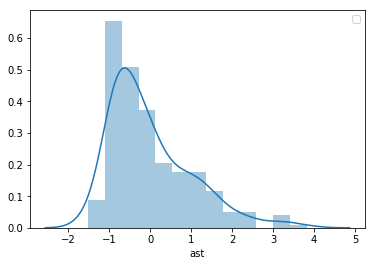

In [114]:
sns.distplot(statsTable.ast)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


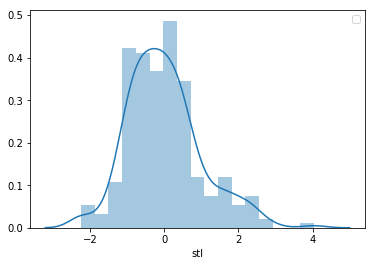

In [115]:
sns.distplot(statsTable.stl)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


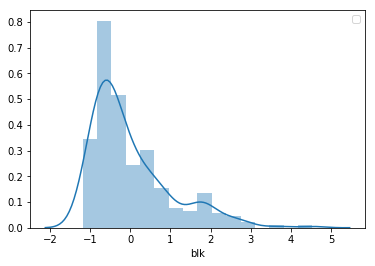

In [116]:
sns.distplot(statsTable.blk)
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


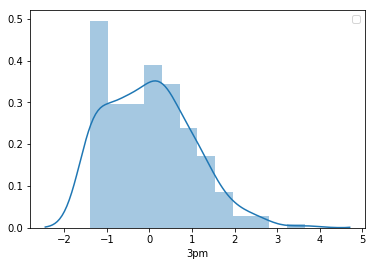

In [118]:
sns.distplot(statsTable['3pm'])
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


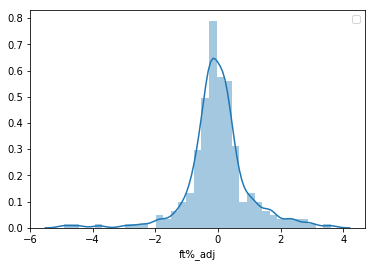

In [119]:
sns.distplot(statsTable['ft%_adj'])
plt.legend()
plt.show()

/Users/codyschank/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
No handles with labels found to put in legend.


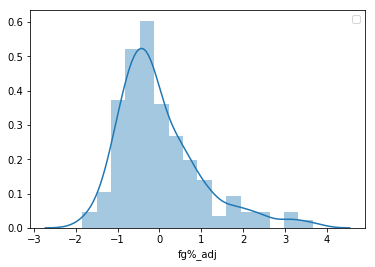

In [120]:
sns.distplot(statsTable['fg%_adj'])
plt.legend()
plt.show()